In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = "sea"

In [4]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("sea").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [6]:
image_df

,Filepath,Label
0,sea\Corals\10465606544_52913a3632_o.jpg,Corals
1,sea\Corals\10465800323_cb0dec6996_o.jpg,Corals
2,sea\Corals\10466334974_85c531844d_o.jpg,Corals
3,sea\Corals\10466516113_b28dbc5d17_o.jpg,Corals
4,sea\Corals\10694747335_e048ab5dc4_o.jpg,Corals
...,...,...
23479,sea\Turtle_Tortoise\Turtle_Tortoise (4).png,Turtle_Tortoise
23480,sea\Turtle_Tortoise\Turtle_Tortoise (5).png,Turtle_Tortoise
23481,sea\Whale\26230145276_f36d16e6ea_o.png,Whale
23482,sea\Whale\29257543732_f9fd03998b_o.png,Whale


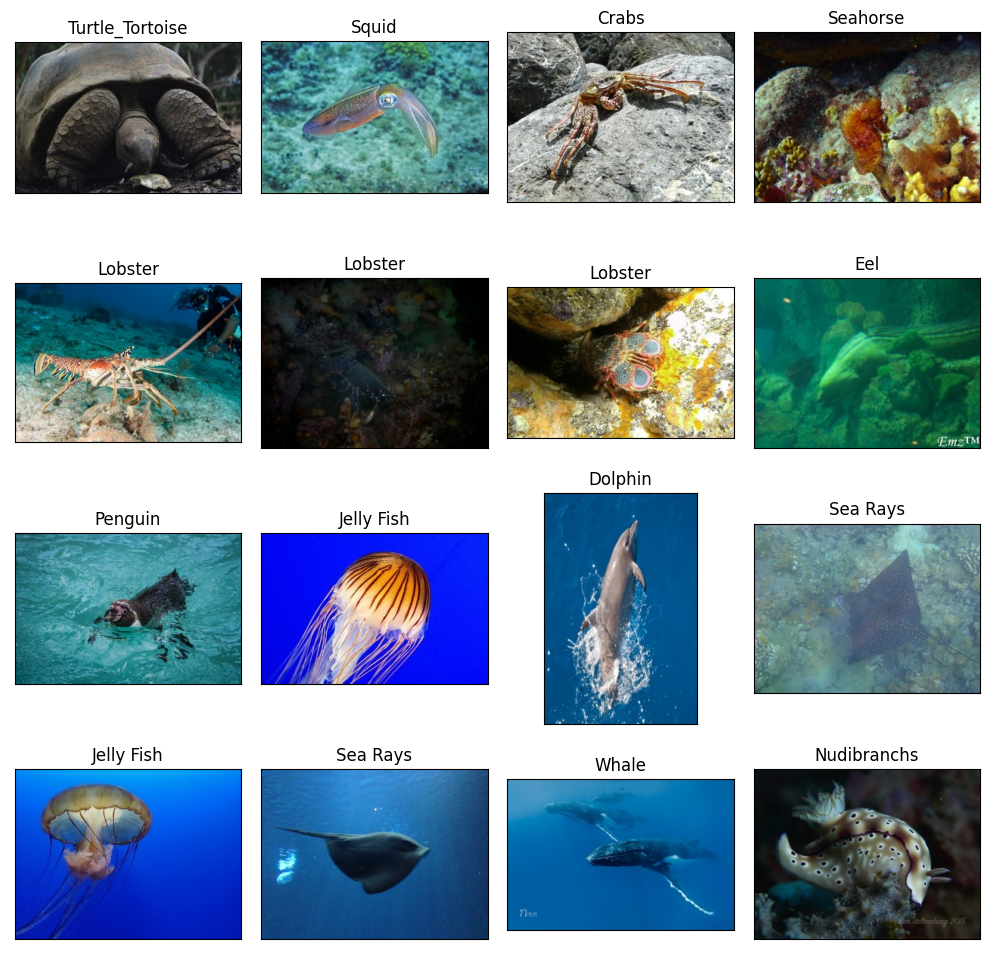

<Figure size 640x480 with 0 Axes>

In [10]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()
plt.savefig('image.jpg')

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                  shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = 'nearest',
    validation_split=0.2) # set validation split

In [38]:
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 9402 images belonging to 19 classes.
Found 2340 images belonging to 19 classes.


In [39]:
mobile_model = Sequential()

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

mobile_model.add(pretrained_model)

9406464/9406464 [==============================] - 1s 0us/step


In [40]:
mobile_model.add(Flatten())
mobile_model.add(Dense(512, activation='relu'))
mobile_model.add(Dropout(0.2))
mobile_model.add(Dense(19, activation='softmax'))

In [41]:
mobile_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 19)                9747      
                                                                 
Total params: 2,923,603
Trainable params: 665,619
Non-trainable params: 2,257,984
______________________________________

In [42]:
mobile_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

history = mobile_model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
294/294 [==============================] - 325s 1s/step - loss: 1.1643 - accuracy: 0.6482 - val_loss: 0.8529 - val_accuracy: 0.7244
Epoch 2/10
294/294 [==============================] - 237s 805ms/step - loss: 0.8454 - accuracy: 0.7379 - val_loss: 0.7373 - val_accuracy: 0.7671
Epoch 3/10
294/294 [==============================] - 239s 811ms/step - loss: 0.7772 - accuracy: 0.7523 - val_loss: 0.7069 - val_accuracy: 0.7748
Epoch 4/10
294/294 [==============================] - 239s 814ms/step - loss: 0.7100 - accuracy: 0.7770 - val_loss: 0.7328 - val_accuracy: 0.7692
Epoch 5/10
294/294 [==============================] - 253s 860ms/step - loss: 0.6648 - accuracy: 0.7897 - val_loss: 0.7001 - val_accuracy: 0.7722
Epoch 6/10
294/294 [==============================] - 278s 946ms/step - loss: 0.6421 - accuracy: 0.7965 - val_loss: 0.6920 - val_accuracy: 0.7752
Epoch 7/10
294/294 [==============================] - 272s 925ms/step - loss: 0.6282 - accuracy: 0.7998 - val_loss: 0.6892 - va

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

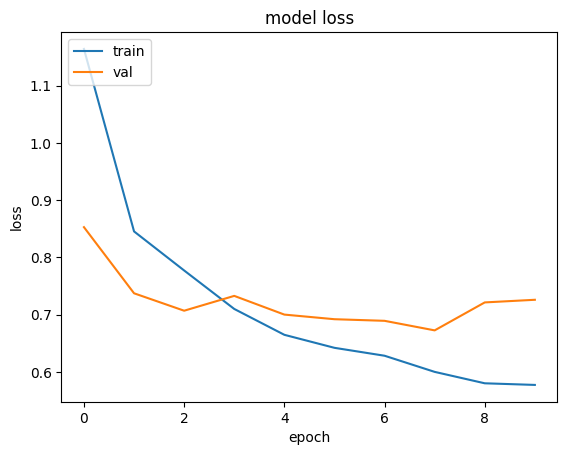

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
mobile_model.save("model.h5")